## Diffusion as composite of Fick's law and mass conservation

In [101]:
using Catlab, Catlab.CategoricalAlgebra, Catlab.Graphics, Catlab.Programs
using CombinatorialSpaces.ExteriorCalculus
using Catlab.Graphics.Graphviz

draw(d) = to_graphviz(d, box_labels=:name, junction_labels=:variable,
            graph_attrs=Dict(:start => "2"), port_labels=true)



draw (generic function with 1 method)

In [102]:
using Catlab.Graphs
using Catlab.Graphs.BasicGraphs
function to_graph(J::FinCat)
    g = BasicGraphs.Graph()
    copy_parts!(g, graph(J))
    return g
end

Graphics.to_graphviz(F::FinFunctor; kw...) =
to_graphviz(GraphvizGraphs.to_graphviz_property_graph(F; kw...))

function GraphvizGraphs.to_graphviz_property_graph(F::FinFunctor; kw...)
    simplify_vname(s) = Dict(
        "Form0(X)" => "Ω₀",
        "Form1(X)" => "Ω₁",
        "Form2(X)" => "Ω₂",
        "DualForm0(X)" => "Ω̃₀",
        "DualForm1(X)" => "Ω̃₁",
        "DualForm2(X)" => "Ω̃₂",
    )[string(s)]
    
    simplify_ename(s) = begin
        b = IOBuffer()
        show_unicode(b, s)
        return replace(String(take!(b)), r"{.*}"=>"")
    end
    
    J = dom(F)
    G = graph(J)
    pg = GraphvizGraphs.to_graphviz_property_graph(to_graph(J); kw...)
    for v in vertices(G)
        lᵥ = G[v, :vname]
        tᵥ = simplify_vname(F.ob_map[v])
        set_vprops!(pg, v, Dict(:label => "$(lᵥ):$tᵥ"))
    end
    for e in edges(G)
        tₑ = F.hom_map[e]
        set_eprops!(pg, e, Dict(:label => "$(simplify_ename(tₑ))"))
    end
    pg
end


Graphics.to_graphviz(cosp::OpenDiagram; kw...) =
to_graphviz(GraphvizGraphs.to_graphviz_property_graph(cosp; kw...))


function GraphvizGraphs.to_graphviz_property_graph(cosp::OpenDiagram; kw...)
    pg = GraphvizGraphs.to_graphviz_property_graph(cosp.functor; kw...)
    label(I, l, i) = length(dom(l)) > 1 ? "$(i):$I" : "$I"
    for (I,l) in enumerate(legs(cosp.cospan))
        for i in dom(l)
            v = add_vertex!(pg)
            set_vprops!(pg, v, Dict(:label=>label(I, l,i), :shape=>"circle", :color=>"blue"))
            e = add_edge!(pg, v, l(i))
            set_eprops!(pg, e, Dict(:style=>"dashed"))
        end
    end
    return pg
end


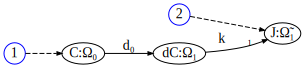

In [103]:
@present DiffusionSpace2D(FreeExtCalc2D) begin
  X::Space
  k::Hom(Form1(X), Form1(X)) # diffusivity of space, usually constant (scalar multiplication)
end

FicksLaw2D = @free_diagram DiffusionSpace2D begin
  C::Form0{X}
  dC::Form1{X}
  J::DualForm1{X}

  dC == d₀{X}(C)
  J == ⋆₁{X}(k(dC))
end
to_graphviz(OpenDiagram(FicksLaw2D, [:C, :J]), node_labels=true, node_attrs=Dict(:shape=>"oval"), prog="dot")


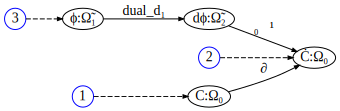

In [104]:

DiffusionConservation2D = @free_diagram DiffusionSpace2D begin
  (C, Ċ)::Form0{X}
  ϕ::DualForm1{X}
  dϕ::DualForm2{X}

  dϕ == dual_d₁{X}(ϕ)
  Ċ == ∂ₜ{Form0{X}}(C)
  Ċ == ⋆₀⁻¹{X}(dϕ)
end;

to_graphviz(OpenDiagram(DiffusionConservation2D, [:C, :Ċ, :ϕ]), node_labels=true, node_attrs=Dict(:shape=>"oval"), prog="dot")


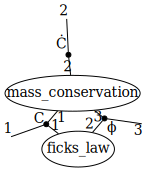

In [105]:
compose_diffusion = @relation (C, Ċ, ϕ) begin
  ficks_law(C, ϕ)
  mass_conservation(C, Ċ, ϕ)
end

draw(compose_diffusion)

In [106]:
using Decapods.OpenDiagrams

composed_diffusion = oapply(compose_diffusion, [
    OpenDiagram(FicksLaw2D, [:C, :J]),
    OpenDiagram(DiffusionConservation2D, [:C, :Ċ, :ϕ]),
]);


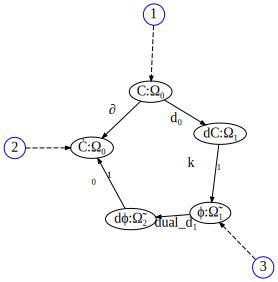

In [107]:

to_graphviz(composed_diffusion, node_labels=true, node_attrs=Dict(:shape=>"oval"), prog="neato")

Compare composite diagram with explicitly constructed diagram.

In [108]:
using Test

Diffusion2D = @free_diagram DiffusionSpace2D begin
  (C, Ċ)::Form0{X}
  dC::Form1{X}
  ϕ::DualForm1{X}
  dϕ::DualForm2{X}

  Ċ == ∂ₜ{Form0{X}}(C)
  dC == d₀{X}(C)
  ϕ == ⋆₁{X}(k(dC))
  dϕ == dual_d₁{X}(ϕ)
  Ċ == ⋆₀⁻¹{X}(dϕ)
end

ComposedDiffusion2D = apex(composed_diffusion)
f = isomorphism(graph(dom(ComposedDiffusion2D)), graph(dom(Diffusion2D)))
@test !isnothing(f)
F = FinFunctor(map(collect, components(f)), dom(ComposedDiffusion2D), dom(Diffusion2D))
@test ComposedDiffusion2D == compose(F, Diffusion2D)

Test Passed